# Burn In Test
A test file to demonstrate the issues with starting positions in multi-modal distributions

In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from numpyro import infer, distributions
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

/home/hughmc/anaconda3/envs/nestconda_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
width = .25
relheight = 0
spacing = 3

xmin=-10
xmax=10
ymin=-10
ymax=10

def potential(x,y):
    
    out=0
    
    #low likelihood peaks
    out+=jnp.exp(-1/2* (jnp.power((x-spacing),2) + jnp.power(y,2)) / width**2) * 0.5
    out+=jnp.exp(-1/2* (jnp.power((x+spacing),2) + jnp.power(y,2))/ width**2) 
    out+=jnp.exp(-1/2* (jnp.power((x),2)   + jnp.power(y-spacing,2))/ width**2) 
    out+=jnp.exp(-1/2* (jnp.power((x),2)   + jnp.power(y+spacing,2))/ width**2)
    
    #High likelihood peak in middle
    out+=jnp.exp(-1/2* (jnp.power((x),2)+jnp.power(y,2))/ width**2)*relheight
    
    return(out)


def model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))
    
    numpyro.factor('potfunc',jnp.log(potential(x,y) + 1E-15))

Conside the simple multi-modal distribution defined above. It has 4 fully separated gaussian peaks in a cross pattern, with  the one on the right half the height / peak likelihood of the others. A good MCMC run should find all of these peaks and their heights:

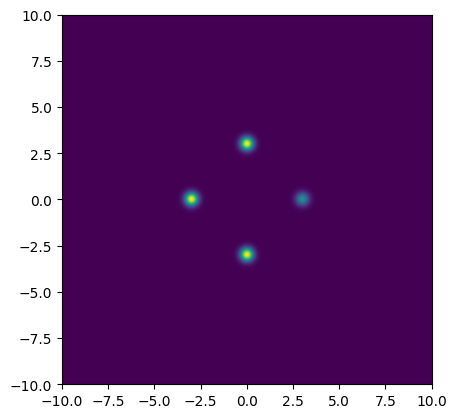

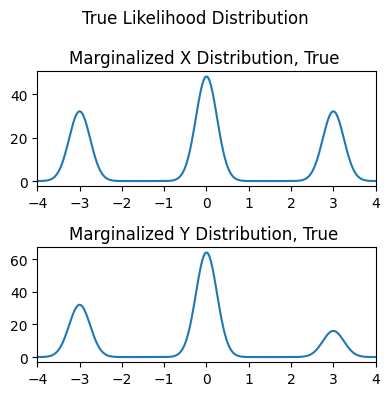

In [3]:
plt.figure()
nplot = 1024
xplot = jnp.linspace(xmin,xmax, nplot)
yplot = jnp.linspace(ymin,ymax, nplot)
X,Y = jnp.meshgrid(xplot, yplot)
Z = potential(X,Y)
plt.imshow(Z[::-1,::], extent = [xmin, xmax, ymin, ymax])
plt.show()

fig,ax=plt.subplots(2,1,figsize=(4,4))
ax[0].plot( xplot, np.sum(Z,axis=1))
ax[1].plot( yplot, np.sum(Z,axis=0))
ax[0].set_xlim([-4,4])
ax[1].set_xlim([-4,4])
ax[0].set_title("Marginalized X Distribution, True ")
ax[1].set_title("Marginalized Y Distribution, True ")
fig.suptitle("True Likelihood Distribution")
fig.tight_layout()
plt.show()

## NUTS
Let's test this how well NUTS recovers this distribution by throwing chains with uniform start positions, like we would use to recover lags in AGN RM:

Every chain needs to end at an island. If there are $n_{modes}$ modes, then the chance of landing in any one island is $p=1/n_{modes}$. From this, we can estimate how many chains end up in each mode. For $N$ total chains:

\begin{equation}
N_{i}=pN \pm \sqrt{Np(1-p)} \\
\frac{N_{i}}{N} = p \pm \frac{1}{\sqrt{N}} \frac{\sqrt{(p (1-p)}}{p}
\end{equation}

If we have $n_{modes}=4$, i.e. $p=\frac{1}{m}$, and want to measure this smallest mode accurately to within  $\Delta \frac{N_{i}}{N} < 10 \%$, we need $\approx300$ chains. The number of burn-in steps has been tuned with trial and error to a minimum value of $n_{burn}\approx 200$.

In [4]:
nchains  = 300
nsamples = 100
nburn    = 200
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output=sampler.get_samples()

Starting Sampling...
Sampling Done


Though NUTS does a good job (after burn-in) of locating each of the modes, it <i>doesn't</i> succesfully identify their heights. Because the modes are so fully separated, chains stick to whichever mode they first encounter, and so each mode is equally occupied / has roughly the same height:

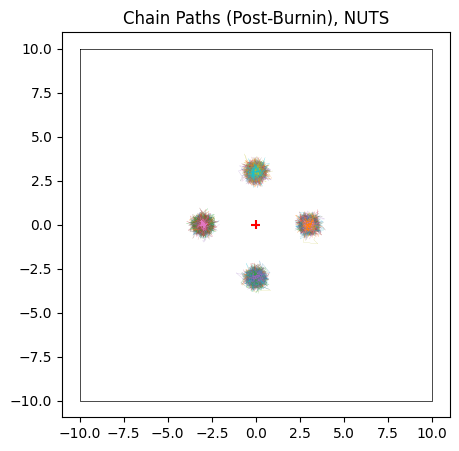

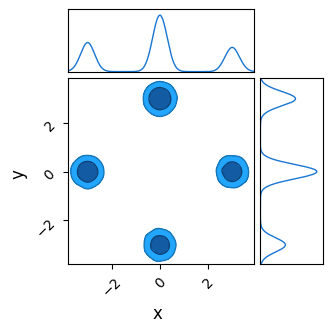

In [5]:
plt.figure(figsize=(5,5))
plt.title("Chain Paths (Post-Burnin), NUTS")
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output['x'][i*nsamples:(i+1)*nsamples],output['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

c= ChainConsumer()
c.add_chain([output['x'],output['y']], parameters=['x','y'], name="NUTS only", color='blue')
c.plotter.plot(chains=['NUTS only'])
plt.show()

## Nested Sampling
Instead, we'll now try nested sampling. In the following, we'll use the same number of evaluations as the burn-in phase of the MCMC ($n_{chains}\times n_{burn}$). The number of live points is as recommended by <i>Albert 2021</i> in their paper introducing `JAXNS`:

\begin{equation}
N_{live} \approx 50 \times N_{modes} \times (Dimensions+1)
\end{equation}

In [6]:
from numpyro.contrib.nested_sampling import NestedSampler

ns = NestedSampler(model, constructor_kwargs={"num_live_points":50*4*(2+1), "max_samples":nchains*nburn})
print("Doing Nested Sampling")
ns.run(jax.random.PRNGKey(0))
print("Done")

Doing Nested Sampling
Done


In the same number of evaluations as NUTS needed to burn-in, nested sampling has identified the modes, accurately identified their heights, and done a decent job of getting their overall shape as well.

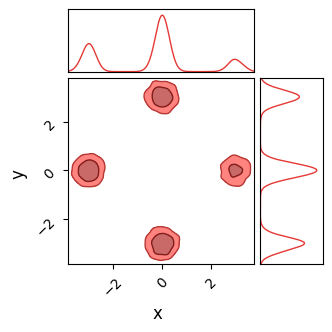

In [7]:
output_ns=ns.get_samples(jax.random.PRNGKey(0),nchains*nsamples)

c.add_chain([output_ns['x'],output_ns['y']], parameters=['x','y'], name='NS only', color='red')
c.plotter.plot(chains=['NS only'])
plt.show()

# Using Nested Sampling In Place of  Burn-In
We can use a single nested sampling run to identify the shapes and locations of the contours, and then use a sufficient number of HMC chains to refine these.

In [8]:
ns_burnin = NestedSampler(model, constructor_kwargs={"num_live_points":50*4*(2+1), "max_samples":50*4*(2+1)})
print("Doing Nested Sampling")
ns_burnin.run(jax.random.PRNGKey(0))
print("Done")

Doing Nested Sampling
Done


In [9]:
start_positions = ns_burnin.get_samples(jax.random.PRNGKey(1),nchains) # Get starting pos
#--------
#Perform some strange NumPyro Magic
from numpyro.infer.util import transform_fn
transforms = {"x": numpyro.distributions.biject_to(numpyro.distributions.Uniform(xmin, xmax).support),
              "y": numpyro.distributions.biject_to(numpyro.distributions.Uniform(ymin, ymax).support)}
params = transform_fn(transforms, start_positions, invert=True)
#--------
#Pass this to sampler.run(jax.random.PRNGKey(1), init_params=params)

We then feed this 'transformed' dictionary to the numpyro sampler at the sampler.run() step

In [10]:
print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    infer.NUTS(model = model, step_size = 0.05),
    num_warmup  =100,
    num_samples =nsamples,
    num_chains  =nchains,
    progress_bar=False,
    chain_method = 'sequential',
)

sampler.run(jax.random.PRNGKey(1), init_params=params)
output_nestedburnin=sampler.get_samples()
print("Done")

Beginning sampling...
Done


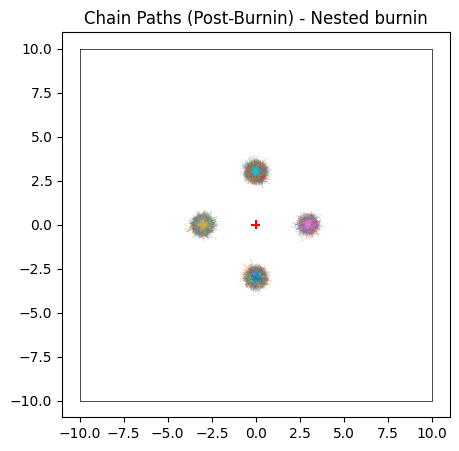

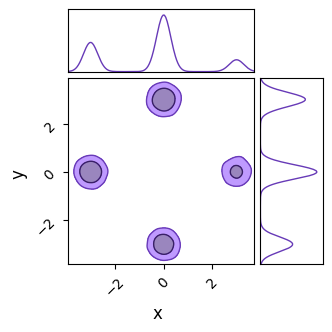

In [11]:
plt.figure(figsize=(5,5))
plt.title("Chain Paths (Post-Burnin) - Nested burnin")
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output_nestedburnin['x'][i*nsamples:(i+1)*nsamples],output_nestedburnin['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

c.add_chain([output_nestedburnin['x'],output_nestedburnin['y']], parameters=['x','y'], name='NS and NUTS', color = 'purple')
c.plotter.plot(chains=['NS and NUTS'])
plt.show()

# Sample-Adaptive Sampler
NumPyro also has a gradient free sampler "SA", the "Sample-Adaptive Sampler". We'll test that too for completeness. Without  HMC's sense of direction, this needs a much longer burn-in for each chain, around $n_{burn}=400$. Even after burn-in, chains will still take the ocassional excursion into low likelihood space, giving much messier overall contours (I tested this as far as $n_{burn}=1000$ and these spikes didn't disappear)

In [ ]:
nchains  = 300
nsamples = 100
nburn    = 400
sampler = numpyro.infer.MCMC(
    numpyro.infer.SA(model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_SA =sampler.get_samples()

Starting Sampling...


Unlike NUTS, in which each chain sticks to the first mode it finds, SA's less sophisticated pathfinding lets is hop between islands. For the same number of chains and samples, SA does a better job of recovering the true distribution, but at the cost of being much less efficient.

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Chain Paths (Post-Burnin) for SA")
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output_SA['x'][i*nsamples:(i+1)*nsamples],output_SA['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

c.add_chain([output_SA['x'],output_SA['y']], parameters=['x','y'], name = 'olive', shade = True)
c.plotter.plot(chains=['SA'])
plt.show()

# When Flat-space Isn't Flat

In the previous example, we considered only the simple case of a 'smooth' posterior. Under these cases, HMC returns results that are a bit skewed, but not entirely unreasonable. However, HMC can fail entirely if the inter-modal 'flat' space isn't flat. Its leveraging of gradients makes it extremely susceptible to getting pinned against any features of 'roughness' in the likelihood function

Like before, we'll create a potential function and send it to NumPyro, but this time adding a semi-regular 'noise'

In [ ]:
def bad_potential(x,y):
    return potential(x,y) + (jnp.exp(jnp.sin(10*x)/2) * jnp.exp(jnp.sin(10*y)/8) -0.5) * 0.001

def bad_model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))
    
    numpyro.factor('potfunc',jnp.log(bad_potential(x,y) + 1E-14))

This 'noise' is very low contrast, the peaks and valleys it forms are not even visible when looking at the marginalized likelihood, but are still very much present.

In [ ]:
nplot = 1024
Z2 = bad_potential(X,Y)

fig_grid, ax_grid = plt.subplots(1,2, figsize=(8,4))

ax_grid[0].imshow(np.log(Z2[::-1,::]), extent = [xmin, xmax, ymin, ymax])
ax_grid[1].imshow(Z2[::-1,::], extent = [xmin, xmax, ymin, ymax])
ax_grid[0].set_title("Likelihood")
ax_grid[1].set_title("Log Likelihood")

fig_grid.tight_layout()

#---------------------

fig, ax=plt.subplots(2,1,figsize=(4,4))

ax[0].plot( xplot, np.sum(Z,axis=1))
ax[1].plot( yplot, np.sum(Z,axis=0))
ax[0].set_xlim([-4,4])
ax[1].set_xlim([-4,4])
ax[0].set_title("Marginalized X Distribution")
ax[1].set_title("Marginalized Y Distribution")

fig.tight_layout()
plt.show()

Now, try running HMC on this distribution:

In [ ]:
nchains  = 3
nsamples = 100
nburn    = 200
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(bad_model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output=sampler.get_samples()

And we see that it fails completely. The chains cannot navigate past the 'walls' of noise in any reasonable burn-in time.

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Chain Paths (Post-Burnin), HMC Only")
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output['x'][i*nsamples:(i+1)*nsamples],output['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

c2= ChainConsumer()
c2.add_chain([output['x'],output['y']], parameters=['x','y'], name = 'HMC only')
c2.plotter.plot(chains=['HMC only'], extents=[[xmin,xmax],[ymin,ymax]])
plt.show()

Fortunately, we nested sampling performs much better in  these cases.

In [ ]:
from numpyro.contrib.nested_sampling import NestedSampler

num_live = 50*4*(2+1)
num_evals = num_live * 5
ns = NestedSampler(bad_model, constructor_kwargs={"num_live_points":num_live, "max_samples":num_evals})
print("Doing Nested Sampling")
ns.run(jax.random.PRNGKey(0))
print("Done")

In [ ]:
output_ns=ns.get_samples(jax.random.PRNGKey(0), nchains*nsamples)

c2.add_chain([output_ns['x'],output_ns['y']], parameters=['x','y'], name='NS', color = 'red', shade=True)
c2.plotter.plot(chains=['NS'])
plt.show()